# Mutation data filtering and propagation
In this notebook, I perform two pre-processing on the mutation data, namely:
<ul>
    <li> A: Hard threshold on the frequency in the dataset, to remove lowly frequent mutations, most likely akin to noise.
</ul>

In [1]:
import pandas as pd
import numpy as np
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams

fpath = os.path.join(rcParams["datapath"], "fonts/ttf/arial.ttf")
prop_label = fm.FontProperties(fname=fpath)
prop_label.set_size(30)
prop_ticks = fm.FontProperties(fname=fpath)
prop_ticks.set_size(25)
fname = os.path.split(fpath)[1]
sns.set_style("whitegrid")
sns.set_context("paper")


Bad key "text.kerning_factor" on line 4 in
/home/s.mourragui/.conda/envs/trickle_down/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Import all mutation data

In [2]:
all_mutations_file = '/DATA/s.mourragui/data/2020_10_GDSC_data/mutations/all_mutations_data.pkl'
all_mut_df = pd.read_pickle(all_mutations_file, compression='gzip')

## Hard threshold
We here fix a hard-threshold and filter mutation data
### View of mutation frequency
For each gene, we compute the proportion of samples mutated. The number of genes with a certain proportion of mutated samples is then displayed.

/home/s.mourragui/.conda/envs/trickle_down/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


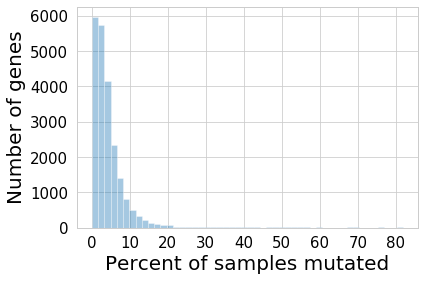

/home/s.mourragui/.conda/envs/trickle_down/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


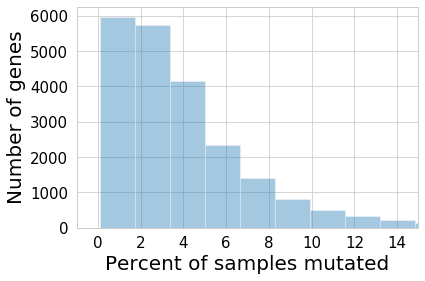

In [123]:
all_mut_freq = np.sum(all_mut_df, axis=0)
sns.distplot(all_mut_freq / all_mut_df.shape[0]*100, kde=False)
plt.xticks(fontsize=15, color='black')
plt.xlabel('Percent of samples mutated', fontsize=20, color='black')
plt.ylabel('Number of genes', fontsize=20, color='black')
plt.yticks(fontsize=15, color='black')
plt.tight_layout()
plt.savefig('./figures/mutation_frequency_all.png', dpi=300)
plt.show()

all_mut_freq = np.sum(all_mut_df, axis=0)
sns.distplot(all_mut_freq / all_mut_df.shape[0]*100, kde=False)
plt.xticks(fontsize=15, color='black')
plt.xlabel('Percent of samples mutated', fontsize=20, color='black')
plt.ylabel('Number of genes', fontsize=20, color='black')
plt.yticks(fontsize=15, color='black')
plt.xlim(-1,15)
plt.tight_layout()
plt.savefig('./figures/mutation_frequency_all_zoomed.png', dpi=300)

Effect of threshold on the number of genes.

/home/s.mourragui/.conda/envs/trickle_down/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


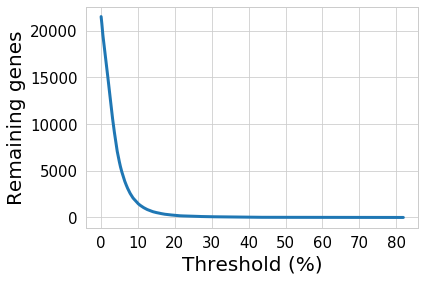

/home/s.mourragui/.conda/envs/trickle_down/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


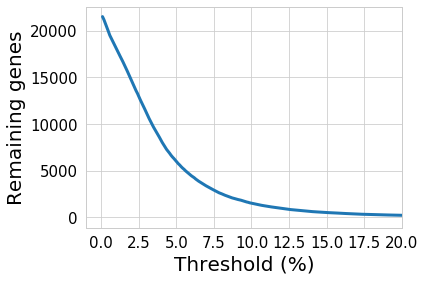

In [124]:
unique_mutation_count = np.unique(all_mut_freq)
remaining_genes_by_threshold = [np.sum(all_mut_freq > x) for x in unique_mutation_count]

sns.lineplot(unique_mutation_count/all_mut_df.shape[0]*100,
             remaining_genes_by_threshold,
             linewidth=3)
plt.xticks(fontsize=15, color='black')
plt.yticks(fontsize=15, color='black')
plt.xlabel('Threshold (%)', fontsize=20, color='black')
plt.ylabel('Remaining genes', fontsize=20, color='black')
plt.tight_layout()
plt.savefig('./figures/number_remaining_genes_thresholded.png', dpi=300)
plt.show()

sns.lineplot(unique_mutation_count/all_mut_df.shape[0]*100, 
             remaining_genes_by_threshold, 
             linewidth=3)
plt.xticks(fontsize=15, color='black')
plt.yticks(fontsize=15, color='black')
plt.xlabel('Threshold (%)', fontsize=20, color='black')
plt.ylabel('Remaining genes', fontsize=20, color='black')
plt.xlim(-1,20)
plt.tight_layout()
plt.savefig('./figures/number_remaining_genes_thresholded.png', dpi=300)

## By tissue type

In [125]:
tissue_mut_df = all_mut_df.reset_index()
tissue_mut_df.columns = ['sample', 'tissue'] + list(all_mut_df.columns)
del tissue_mut_df['sample']

In [126]:
tissue_of_interest = 'HAEMATOPOIETIC AND LYMPHOID'
tissue_mut_df['tissue'] = (tissue_mut_df['tissue'] == tissue_of_interest )
tissue_mut_df = tissue_mut_df.groupby('tissue').agg('mean')
tissue_mut_df = tissue_mut_df.T

tissue_mut_df['other'] = tissue_mut_df[0]
tissue_mut_df[tissue_of_interest] = tissue_mut_df[1]

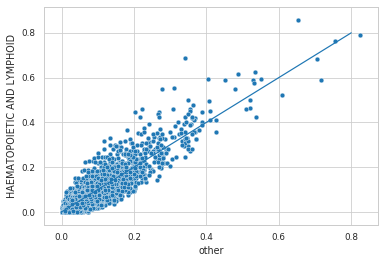

In [127]:
sns.scatterplot(data=tissue_mut_df, x='other', y=tissue_of_interest)
plt.plot([0,.8], [0,.8])

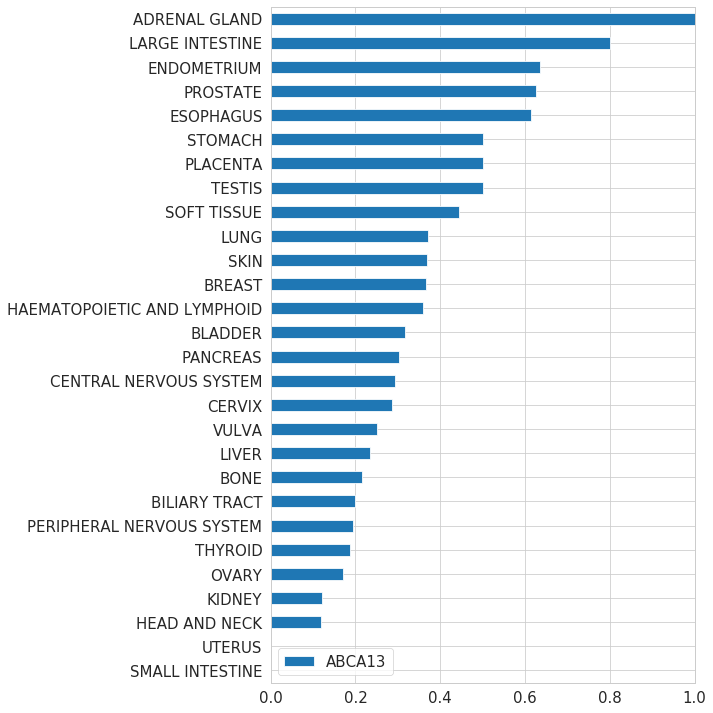

In [142]:
gene = 'ABCA13'

gene_mut_df = all_mut_df[[gene]].reset_index()
gene_mut_df.columns = ['sample', 'tissue', gene]
del gene_mut_df['sample']
gene_mut_df = gene_mut_df.groupby('tissue').aggregate('mean').sort_values(by=gene)

gene_mut_df.plot.barh(figsize=(10,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('')
plt.legend(fontsize=15)
plt.xlim(0,1)
plt.tight_layout()

plt.show()

A threshold at 5% sounds like a good trade-off. Kuenzi et al considered top 15%, which is around 3000 genes here. We also consider this threshold.

### Proportion filtering and saving data

In [5]:
threshold = 0.05
all_mut_freq_percent = all_mut_freq / all_mut_df.shape[0]
filtered_genes = all_mut_freq_percent[all_mut_freq_percent > threshold].index
threshold_mut_df = all_mut_df[filtered_genes]

In [6]:
folder = '/DATA/s.mourragui/data/2020_10_GDSC_data'
subfolders = ['/', '_protein_coding/', '_mini_cancer/']
data_type_label = 'mutations_threshold_%s'%(int(threshold*100))

for sub in subfolders:
    if data_type_label not in os.listdir(folder + sub):
        os.mkdir(folder + sub + data_type_label)
    threshold_mut_df.to_pickle(folder + sub + data_type_label + '/all_%s_data.pkl'%(data_type_label),
                              compression='gzip')

### Number of genes thresholding and saving data

In [132]:
threshold = 3000
all_mut_freq_percent = all_mut_freq / all_mut_df.shape[0]
# filtered_genes = all_mut_freq_percent[all_mut_freq_percent > threshold].index
# threshold_mut_df = all_mut_df[filtered_genes]

In [137]:
all_mut_freq_percent.sort_values(ascending=False).head(threshold)

TTN            0.818798
MUC4           0.756783
MUC12          0.701550
TP53           0.695736
NOTCH2         0.686047
                 ...   
ZNF92          0.074612
PPAN-P2RY11    0.074612
PHC3           0.074612
WDR45          0.074612
MICALL1        0.074612
Length: 3000, dtype: float64

## Mini cancer exploration
Exploration of the proportion of mutated samples when using the mini cancer genome

In [53]:
mini_cancer_mutations_file = '/DATA/s.mourragui/data/2020_10_GDSC_data_mini_cancer//mutations/all_mutations_data.pkl'
mini_mut_df = pd.read_pickle(mini_cancer_mutations_file, compression='gzip')

### Tissue filtering

In [68]:
tissue_mini_mut_df = mini_mut_df.reset_index()
tissue_mini_mut_df.columns = ['sample', 'tissue'] + list(mini_mut_df.columns)
del tissue_mini_mut_df['sample']

In [70]:
tissue_of_interest = 'HAEMATOPOIETIC AND LYMPHOID'
tissue_mini_mut_df = tissue_mini_mut_df.set_index('tissue').sum(axis=1)

In [75]:
tissue_mini_mut_df.sort_values().tail(20)

tissue
HAEMATOPOIETIC AND LYMPHOID     519
LARGE INTESTINE                 544
LARGE INTESTINE                 550
LARGE INTESTINE                 575
ESOPHAGUS                       582
ESOPHAGUS                       588
LARGE INTESTINE                 593
LARGE INTESTINE                 600
ENDOMETRIUM                     607
LARGE INTESTINE                 610
LARGE INTESTINE                 616
HAEMATOPOIETIC AND LYMPHOID     644
LARGE INTESTINE                 655
LARGE INTESTINE                 656
LARGE INTESTINE                 729
LARGE INTESTINE                1199
LARGE INTESTINE                1547
LARGE INTESTINE                1580
LARGE INTESTINE                1626
LARGE INTESTINE                1669
dtype: int64

### Frequency

/home/s.mourragui/.conda/envs/trickle_down/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


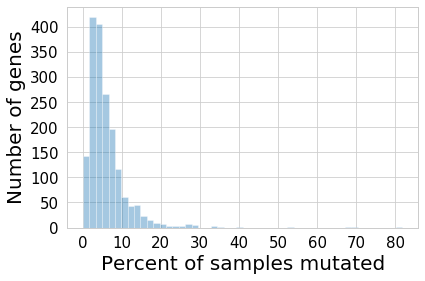

/home/s.mourragui/.conda/envs/trickle_down/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


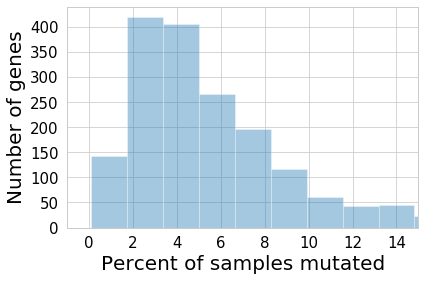

In [76]:
mini_mut_freq = np.sum(mini_mut_df, axis=0)
sns.distplot(mini_mut_freq / mini_mut_df.shape[0]*100, kde=False)
plt.xticks(fontsize=15, color='black')
plt.xlabel('Percent of samples mutated', fontsize=20, color='black')
plt.ylabel('Number of genes', fontsize=20, color='black')
plt.yticks(fontsize=15, color='black')
plt.tight_layout()
# plt.savefig('./figures/mutation_frequency_all.png', dpi=300)
plt.show()

mini_mut_freq = np.sum(mini_mut_df, axis=0)
sns.distplot(mini_mut_freq / mini_mut_df.shape[0]*100, kde=False)
plt.xticks(fontsize=15, color='black')
plt.xlabel('Percent of samples mutated', fontsize=20, color='black')
plt.ylabel('Number of genes', fontsize=20, color='black')
plt.yticks(fontsize=15, color='black')
plt.xlim(-1,15)
plt.tight_layout()
# plt.savefig('./figures/mutation_frequency_all_zoomed.png', dpi=300)

In [100]:
np.sort(np.unique(all_mut_df[all_mut_df[gene] == 0][gene].index.get_level_values(1)).astype(str))

array(['ADRENAL GLAND', 'BILIARY TRACT', 'BLADDER', 'BONE', 'BREAST',
       'CENTRAL NERVOUS SYSTEM', 'CERVIX', 'ENDOMETRIUM', 'ESOPHAGUS',
       'HAEMATOPOIETIC AND LYMPHOID', 'HEAD AND NECK', 'KIDNEY',
       'LARGE INTESTINE', 'LIVER', 'LUNG', 'OVARY', 'PANCREAS',
       'PERIPHERAL NERVOUS SYSTEM', 'PLACENTA', 'PROSTATE', 'SKIN',
       'SOFT TISSUE', 'STOMACH', 'TESTIS', 'THYROID', 'UTERUS', 'VULVA'],
      dtype='<U27')

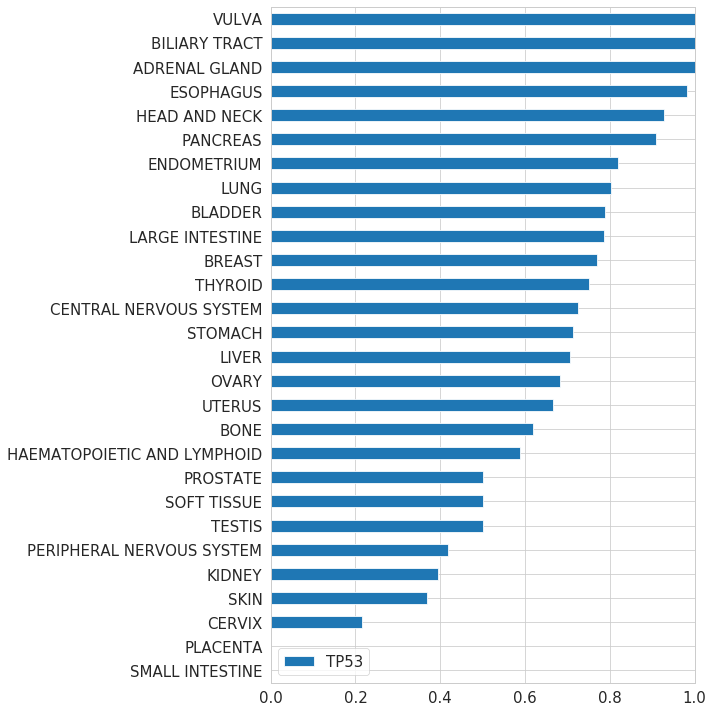

In [141]:
gene = 'TP53'

gene_mut_df = mini_mut_df[[gene]].reset_index()
gene_mut_df.columns = ['sample', 'tissue', gene]
del gene_mut_df['sample']
gene_mut_df = gene_mut_df.groupby('tissue').aggregate('mean').sort_values(by=gene)

gene_mut_df.plot.barh(figsize=(10,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('')
plt.legend(fontsize=15)
plt.xlim(0,1)
plt.tight_layout()

plt.show()

## Removing mutations without effect (synonymous)

In [12]:
raw_mut_df = pd.read_csv('https://cog.sanger.ac.uk/cmp/download/mutations_20191101.zip')

In [23]:
proportion_synonymous = raw_mut_df[raw_mut_df['protein_mutation'] == '-'].shape[0] / raw_mut_df.shape[0] * 100
print('%2.1f %% of synonymous mutations'%(proportion_synonymous))

filtered_mut_df = raw_mut_df[raw_mut_df['protein_mutation'] != '-']

52.9 % of synonymous mutations


In [22]:
output_folder = '/DATA/s.mourragui/data/2020_10_GDSC_data/'

# Read models
model_file = '%smodel_list_20191104.csv'%(output_folder)
model_df = pd.read_csv(model_file)

In [24]:
filtered_mut_df = filtered_mut_df[['model_id', 'gene_symbol']]
filtered_mut_df['INDIC'] = 1
filtered_mut_df = filtered_mut_df.pivot_table(columns=['gene_symbol'], 
                                              index='model_id', 
                                              fill_value=0)
filtered_mut_df.columns = filtered_mut_df.columns.droplevel(0)
filtered_mut_df = filtered_mut_df.merge(model_df[['model_name', 'tissue', 'model_id']].set_index('model_id'),
                                        how='left',
                                        left_index=True,
                                        right_index=True)
filtered_mut_df = filtered_mut_df.reset_index(drop=True).set_index(['model_name', 'tissue'])
filtered_mut_df = filtered_mut_df.dropna(axis=1)
filtered_mut_df.index = pd.MultiIndex.from_tuples([(x[0], str(x[1]).upper()) 
                                                   for x in filtered_mut_df.index])

In [39]:
prop_mut_removed = np.sum(np.sum(np.abs(filtered_mut_df - all_mut_df).dropna(axis=1)))/(np.sum(np.sum(all_mut_df)))
print('%2.1f %% mutations binary events removed'%(prop_mut_removed*100))

20.6 % mutations binary events removed


In [15]:
raw_mut_df[raw_mut_df['protein_mutation'] == '-'].shape[0]

950995